# Prediction anonymous
___

This notebook aims to present and show results from two manually scored hypnograms on the same night's recording. One hypnogram is from our dataset, and the other hypnogram was manually scored by an electrophysiologist.

As stated in [this paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2635577/#__ffn_sectitle), significant differences may lay between these two hypnograms, because both scored didn't followed the same scoring manual. Our dataset being made in the early 90s, scorers followed R&K manual, while scorers now generally follow AASM manual.

The recording that was randomly selected is `SC4441EC-Hypnogram.edf`. It corresponds to an 74 year old woman.

Source: Moser, Doris, Peter Anderer, Georg Gruber, Silvia Parapatics, Erna Loretz, Marion Boeck, Gerhard Kloesch, et al. « Sleep Classification According to AASM and Rechtschaffen & Kales: Effects on Sleep Scoring Parameters ». Sleep 32, nᵒ 2 (1 février 2009): 139‑49.


In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
%matplotlib inline

import mne
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.metrics import (confusion_matrix,
                             classification_report,
                             cohen_kappa_score)

from utils import fetch_data
from constants import (SLEEP_STAGES_VALUES,
                       DATASET_SLEEP_STAGES_VALUES,
                       ELECTROPHYSIOLOGIST_SLEEP_STAGES,
                       N_STAGES,
                       EEG_CHANNELS,
                       EPOCH_DURATION,
                       SAMPLING_FREQ)
from models.model_utils import (print_hypnogram)

In [3]:
NB_EPOCHS_AWAKE_MORNING = 60
    
NYQUIST_FREQ = SAMPLING_FREQ/2
MAX_TIME = EPOCH_DURATION - 1. / SAMPLING_FREQ  # tmax in included

SUBJECT = [44]
NIGHT = [1]
FOLDER_NAME = f"./data/subject{SUBJECT[0]}-night{NIGHT[0]}"

In [4]:
df_records = pd.read_csv("./data/recordings-info.csv")
df_records.head(2)

,subject,night,age,sex,LightsOff,NightDuration,LightsOffSecond,StartRecord,StartRecordTimestamp
0,0,1,33,1,1989-04-25 00:38:00,21810.0,30300.0,1989-04-24 16:13:00,609437580.0
1,0,2,33,1,1989-04-25 21:57:00,30330.0,25620.0,1989-04-25 14:50:00,609519000.0


## Extract data
___

In [5]:
def get_hypnogram_from_filenames(signal_filename, hypnogram_filename, is_electrophysiologist=False):

    raw_data = mne.io.read_raw_edf(signal_filename, preload=False, stim_channel=None, verbose=False)
    annot = mne.read_annotations(hypnogram_filename)
    raw_data.set_annotations(annot, emit_warning=False)
    
    info = df_records[(df_records['subject'] == SUBJECT[0]) & (df_records['night'] == NIGHT[0])]
    print(info)

    # Number of seconds since file began
    closed_lights_time = info['LightsOffSecond'].values[0]
    woke_up_time = closed_lights_time + info['NightDuration'].values[0] + NB_EPOCHS_AWAKE_MORNING*EPOCH_DURATION

    raw_data.crop(tmin=closed_lights_time, tmax=min(woke_up_time, raw_data.times[-1]))

    events, annot_event_id = mne.events_from_annotations(
        raw_data,
        event_id=ELECTROPHYSIOLOGIST_SLEEP_STAGES if is_electrophysiologist else DATASET_SLEEP_STAGES_VALUES,
        chunk_duration=EPOCH_DURATION,
        verbose=False)

    # Few files do not have N3 sleep (i.e. SC4202EC-Hypnogram), so we have to filter out key-value pairs that are not in the annotations.
    event_id = { 
        event_key: SLEEP_STAGES_VALUES[event_key] 
        for event_key in SLEEP_STAGES_VALUES
        if SLEEP_STAGES_VALUES[event_key] in annot_event_id.values()
    }

    epochs = mne.Epochs(
        raw=raw_data,
        events=events,
        event_id=event_id,
        tmin=0.,
        tmax=MAX_TIME,
        preload=True,
        baseline=None,
        verbose=False)

    epochs.drop_channels([
     'EOG horizontal',
     'Resp oro-nasal',
     'EMG submental',
     'Temp rectal',
     'Event marker'])

    y = np.array([event[-1] for event in epochs.events])
    
    return y

In [6]:
file_names = fetch_data(subjects=SUBJECT, recording=NIGHT)
print(file_names)

y_physionet = get_hypnogram_from_filenames(file_names[0][0], file_names[0][1])

Using default location ~/mne_data for PHYSIONET_SLEEP...
[['/Users/claudiaonorato/mne_data/physionet-sleep-data/SC4441E0-PSG.edf', '/Users/claudiaonorato/mne_data/physionet-sleep-data/SC4441EC-Hypnogram.edf']]
    subject  night  age  sex            LightsOff  NightDuration  \
84       44      1   74    1  1989-07-04 00:18:00        33840.0   

    LightsOffSecond          StartRecord  StartRecordTimestamp  
84          27480.0  1989-07-03 16:40:00           615487200.0  


In [7]:
y_electrophysiologist = get_hypnogram_from_filenames(
    file_names[0][0],
    f"{FOLDER_NAME}/electrophysiologist_Hypnogram.edf",
    is_electrophysiologist=True
)

    subject  night  age  sex            LightsOff  NightDuration  \
84       44      1   74    1  1989-07-04 00:18:00        33840.0   

    LightsOffSecond          StartRecord  StartRecordTimestamp  
84          27480.0  1989-07-03 16:40:00           615487200.0  


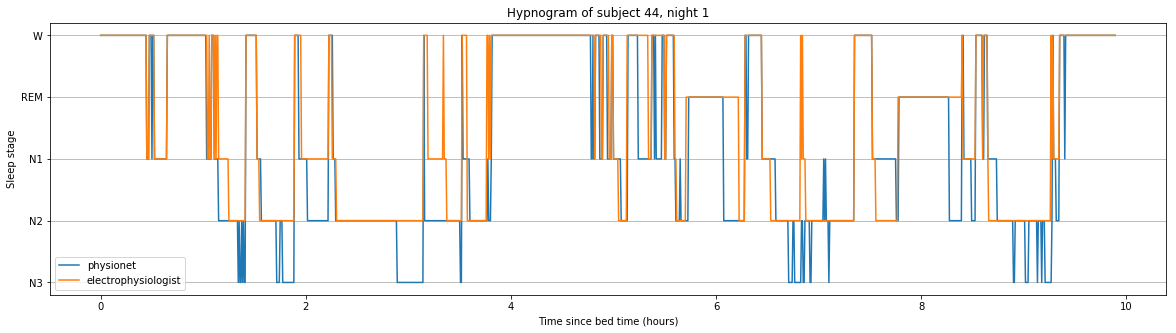

In [8]:
plt.rcParams["figure.figsize"] = (20,5)
print_hypnogram(
    [y_physionet, y_electrophysiologist],
    labels=['physionet', 'electrophysiologist'],
    subject=44,
    night=1
)

In [9]:
print("Matrice de confusion: \n", confusion_matrix(y_physionet, y_electrophysiologist))

print("\n\n", classification_report(y_physionet, y_electrophysiologist, target_names=SLEEP_STAGES_VALUES.keys()))

print("Agreement score (Cohen Kappa): ", cohen_kappa_score(y_physionet, y_electrophysiologist))

Matrice de confusion: 
 [[407   2   0   0   0]
 [ 48  84  51   0   0]
 [  9  74 285   0  37]
 [  2   2  87   0   0]
 [  0   0   0   0 100]]


               precision    recall  f1-score   support

           W       0.87      1.00      0.93       409
          N1       0.52      0.46      0.49       183
          N2       0.67      0.70      0.69       405
          N3       0.00      0.00      0.00        91
         REM       0.73      1.00      0.84       100

    accuracy                           0.74      1188
   macro avg       0.56      0.63      0.59      1188
weighted avg       0.67      0.74      0.70      1188

Agreement score (Cohen Kappa):  0.631587265142547


/Users/claudiaonorato/miniconda3/envs/py3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
electro_hypno = {
    'timestamps': [
        int((datetime.fromtimestamp(615514680) + timedelta(seconds=index*EPOCH_DURATION)).timestamp())
        for index, stage in enumerate(y_electrophysiologist)
    ],
    'stages': [
        str(list(SLEEP_STAGES_VALUES.keys())[list(SLEEP_STAGES_VALUES.values()).index(stage)])
        for index, stage in enumerate(y_electrophysiologist)
    ]
}

with open('data/electrophysiologist_woman78yo_sleepedf.json', 'w') as fp:
    json.dump(dict(epochs=electro_hypno), fp)

In [13]:
sleepedf_hypno = {
    'timestamps': [
        int((datetime.fromtimestamp(615514680) + timedelta(seconds=index*EPOCH_DURATION)).timestamp())
        for index, stage in enumerate(y_physionet)
    ],
    'stages': [
        str(list(SLEEP_STAGES_VALUES.keys())[list(SLEEP_STAGES_VALUES.values()).index(stage)])
        for index, stage in enumerate(y_physionet)
    ]
}

with open('data/physionet_woman78yo_sleepedf.json', 'w') as fp:
    json.dump(dict(epochs=sleepedf_hypno), fp)